In [1]:
import cv2
import mediapipe as mp
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.data import Dataset

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [4]:
%run ../Funkcije.ipynb

In [5]:
train_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Train_Alphabet'
test_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Test_Alphabet'

In [8]:
max_samples = 300
min_samples = 300
img_size = (128, 128)
batch_size = 30

horizontal_flip = True
rotation_range = 25
width_shift_range = .25
height_shift_range = .3
zoom_range = .4

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300
Found 7200 validated image filenames belonging to 24 classes.          for train generator 
Found 2160 validated image filenames belonging to 24 classes.          for valid generator 
Found 2400 validated image filenames belonging to 24 classes.          for test generator 
test batch size:  80   test steps:  30  number of classes :  24


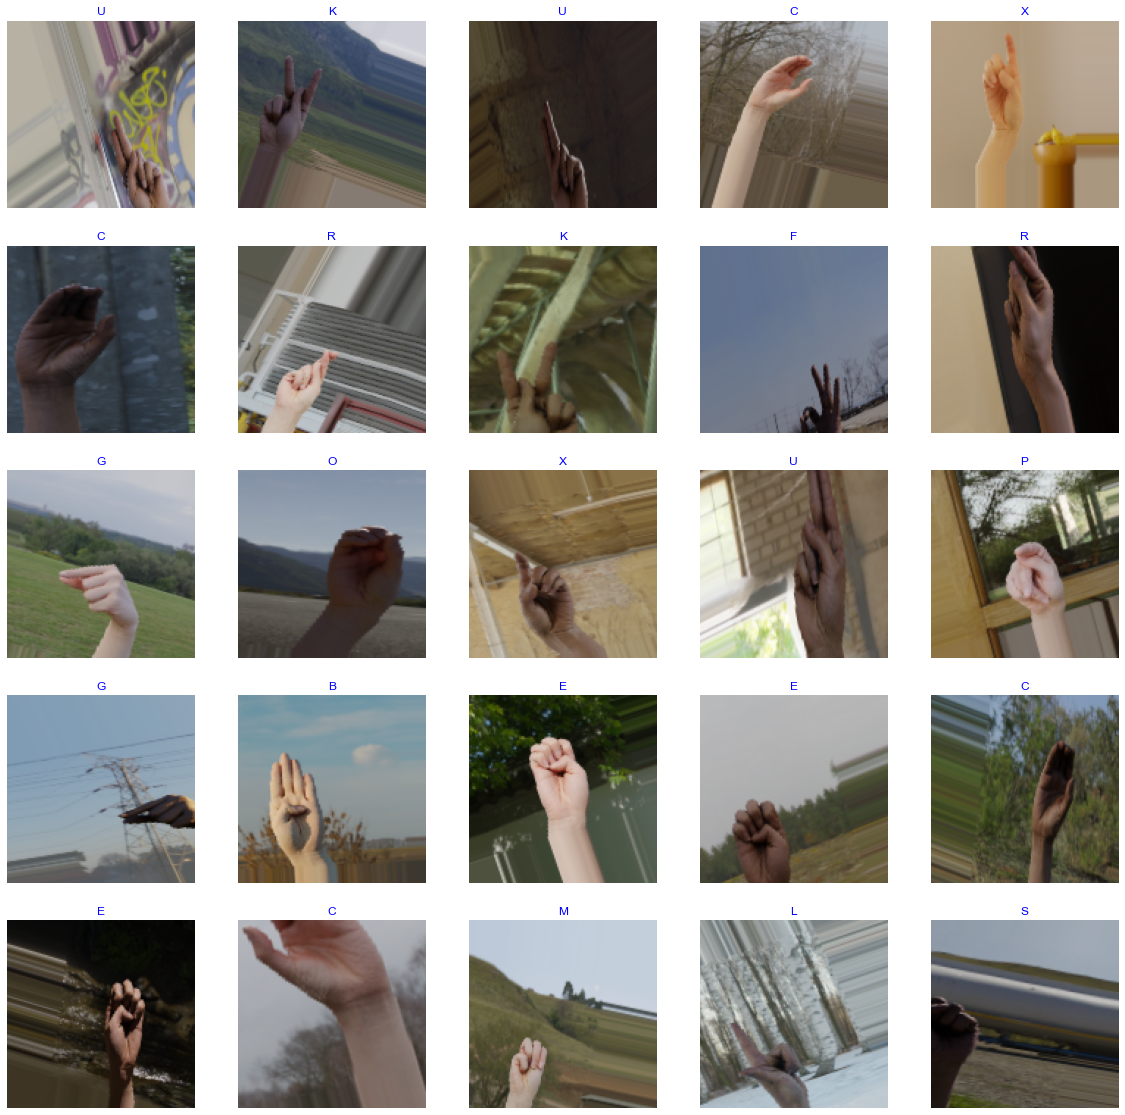

In [9]:
train_gen, test_gen, valid_gen = load_dataset(train_path, test_path,
                                             max_samples = max_samples,
                                             min_samples = min_samples,
                                             img_size = img_size,
                                             batch_size = batch_size,
                                             horizontal_flip = horizontal_flip,
                                             rotation_range = rotation_range,
                                             width_shift_range = width_shift_range,
                                             height_shift_range = height_shift_range,
                                             zoom_range = zoom_range)

In [52]:
train_df

,filepaths,labels
21170,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,Y
18192,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,V
20608,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,X
11152,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,N
12248,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,O
...,...,...
16596,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,T
5573,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,G
1259,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,B
7333,D:\Projekat 2022\dataset\Synthetic ASL Alphabe...,I


In [10]:
def show_image_samples_with_landmarks(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize = (20, 20))
    length = len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(max_num_hands = 1, static_image_mode=True, min_detection_confidence = 0.3)
    mpDraw = mp.solutions.drawing_utils
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i].astype('uint8')
        
        results = hands.process(image)
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                mpDraw.draw_landmarks(image, handLms, mpHands.HAND_CONNECTIONS)

        
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

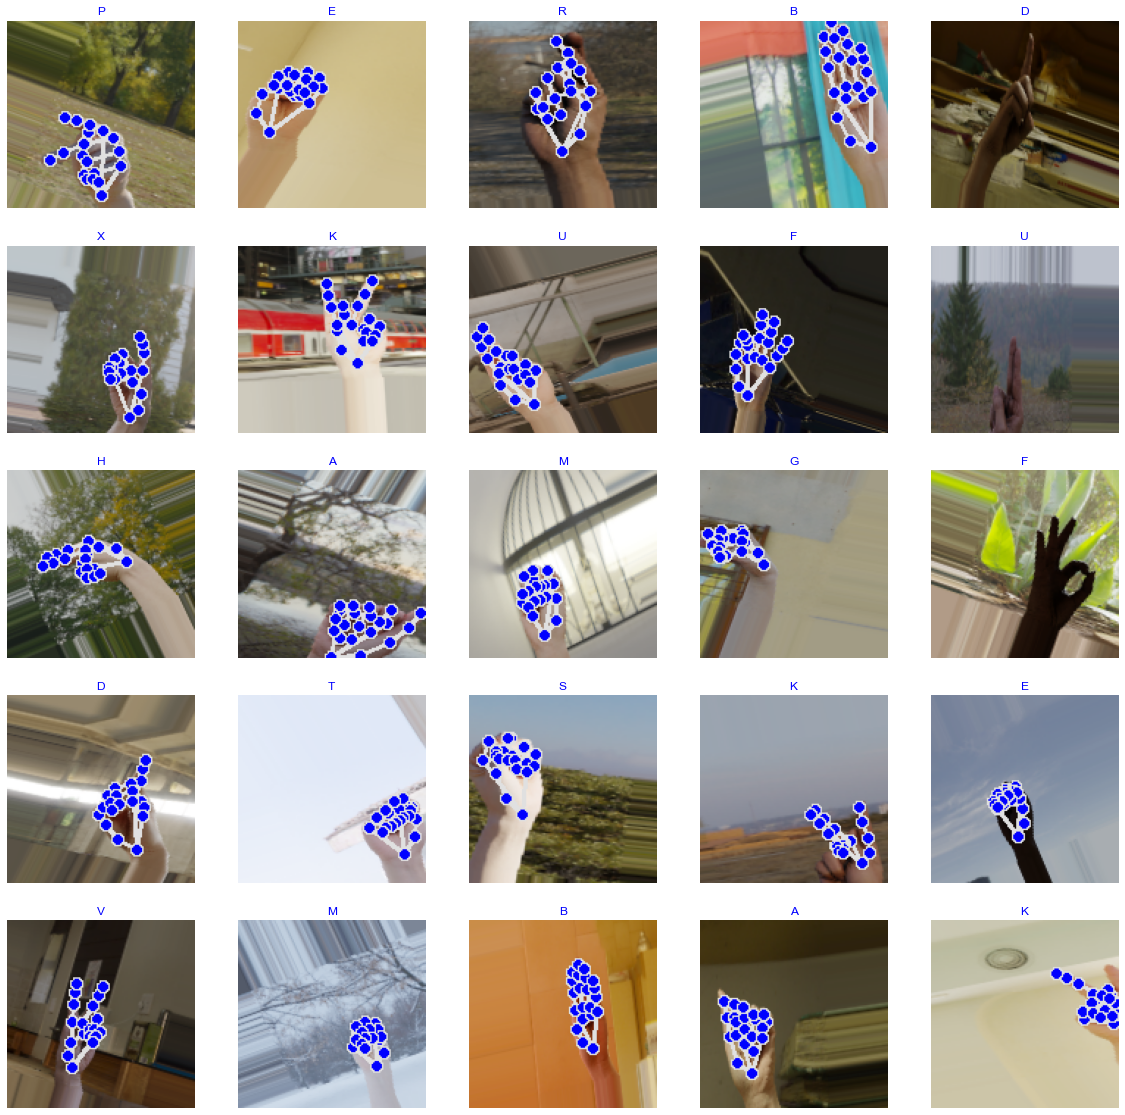

In [11]:
show_image_samples_with_landmarks(train_gen)

In [13]:
import sys

In [245]:
def generate_keypoint_df(generator, num_of_samples):
    
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(max_num_hands = 1, static_image_mode=True, min_detection_confidence = 0.3)
    mpDraw = mp.solutions.drawing_utils
    
    x = np.zeros((num_of_samples, 21))
    y = np.zeros((num_of_samples, 21))
    z = np.zeros((num_of_samples, 21))
    labels = []
    
    samples = 0
    
    for batch in generator:
        for i in range(batch[0].shape[0]):
            img = batch[0][i].astype('uint8')
            label = batch[1][i] 
            
            results = hands.process(img)
            
            if results.multi_hand_landmarks:
                for handLms in results.multi_hand_landmarks:
                    
                    landmarks_x = np.zeros(21)
                    landmarks_y = np.zeros(21)
                    landmarks_z = np.zeros(21)
                    
                    for id, lm in enumerate(handLms.landmark):
                        landmarks_x[id] = lm.x
                        landmarks_y[id] = lm.y
                        landmarks_z[id] = lm.z
                        
                x[samples] = landmarks_x
                y[samples] = landmarks_y
                z[samples] = landmarks_z
                labels.append(label)
                samples += 1
                b = str(samples)
                sys.stdout.write('\r'+ "Generated  " + b + "  samples out of  " + str(num_of_samples) + "  samples")
                #print("Generated  ", samples, "  samples")
                
                if samples >= num_of_samples:
                    break

        if samples >= num_of_samples:
            break
    
    sys.stdout.write('\r'+ "DONE: Generated  " + b + "  samples")
    exit_labels = np.array(labels)
    
    num_of_train_samples = num_of_train_samples
    num_of_test_samples = num_of_test_samples
    num_of_valid_samples = num_of_valid_samples
    
    
    return x, y, z, exit_labels
    
    

In [495]:
import functools
def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, 
  starting at index `i`,
  and combining `n` dimensions
  """
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [14]:
num_of_train_samples = 5000
num_of_test_samples = 1000
num_of_valid_samples = 1000

In [ ]:
train_x, train_y, test_x, test_y, valid_x, valid_y = make_keypoint_database(num_of_train_samples,
                                                                            num_of_test_samples,
                                                                            num_of_valid_samples)

Generated  70  samples out of  5000  samples

In [247]:
new_train_df = make_keypoint_df(train_gen, 50)

DONE: Generated  50  samplesf  50  samples

In [254]:
new_train_df[0].shape

(50, 21)

In [257]:
new_train_df = make_keypoint_df(train_gen, num_of_train_samples)

DONE: Generated  16000  samplesf  16000  samples

In [256]:
new_test_df = make_keypoint_df(train_gen, num_of_test_samples)

DONE: Generated  2000  samplesf  2000  samples

In [258]:
new_valid_df = make_keypoint_df(train_gen, num_of_valid_samples)

DONE: Generated  2000  samplesf  2000  samples

In [244]:
a = np.ones((3,5))
print(a)
b = np.array([1, 2, 3, 4, 5])
a[0] = b
print(a)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 2. 3. 4. 5.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [261]:
NUM_OF_CLASSES = 24

In [ ]:
8, 3443.44, 232332.443

In [493]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_19 (Dropout)        (None, 42)                0         
                                                                 
 dense_31 (Dense)            (None, 42)                1806      
                                                                 
 dropout_20 (Dropout)        (None, 42)                0         
                                                                 
 dense_32 (Dense)            (None, 24)                1032      
                                                                 
 dense_33 (Dense)            (None, 24)                600       
                                                                 
Total params: 3,438
Trainable params: 3,438
Non-trainable params: 0
_________________________________________________________________


In [481]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [482]:
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

In [483]:

# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [484]:
train_db = new_train_df
test_db = new_test_df
valid_db = new_valid_df

In [485]:
train_x = np.array([train_db[0], train_db[1]])
train_y = train_db[3]

test_x = [test_db[0], test_db[1]]
test_y = test_db[3]

valid_x = [valid_db[0], valid_db[1]]
valid_y = valid_db[3]

(2, 16000, 21)


In [486]:
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)

valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

In [487]:
train_x = np.transpose(train_x, (1, 0, 2))
test_x = np.transpose(test_x, (1, 0, 2))
valid_x = np.transpose(valid_x, (1, 0, 2))

In [488]:
train_x = combine_dims(train_x, 1)
test_x = combine_dims(test_x, 1)
valid_x = combine_dims(valid_x, 1)

In [490]:
print(train_x.shape)
print(train_y.shape)

print(valid_x.shape)
print(valid_y.shape)

print(train_x[0])
print(train_y[0])

(16000, 42)
(16000, 24)
(2000, 42)
(2000, 24)
[0.1148398  0.05922688 0.04614894 0.08217552 0.13502234 0.15214831
 0.13734481 0.11753985 0.09413587 0.21477272 0.13451266 0.07982709
 0.04358438 0.25664318 0.16578704 0.11467538 0.07704983 0.28849202
 0.21970704 0.17472228 0.13923851 0.8979497  0.81777042 0.73344803
 0.68033224 0.65830094 0.65629423 0.62516904 0.6145587  0.61078364
 0.67005038 0.71563298 0.76472431 0.8037048  0.71169645 0.76354527
 0.8051675  0.83771402 0.76552284 0.79461533 0.81568259 0.8352623 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [492]:
model.fit(
    train_x,
    train_y,
    epochs=1000,
    batch_size=100,
    validation_data=(valid_x, valid_y),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
152/160 [===========================>..] - ETA: 0s - loss: 0.9961 - accuracy: 0.6951
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 1s 3ms/step - loss: 0.9951 - accuracy: 0.6948 - val_loss: 0.7470 - val_accuracy: 0.8070
Epoch 2/1000
152/160 [===========================>..] - ETA: 0s - loss: 0.9815 - accuracy: 0.6986
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.6978 - val_loss: 0.7446 - val_accuracy: 0.8200
Epoch 3/1000
160/160 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6992
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 1s 3ms/step - loss: 0.9759 - accuracy: 0.6992 - val_loss: 0.7316 - val_accuracy: 0.8230
Epoch 4/1000
147/160 [==========================>...] - ETA: 0s - loss: 0.9817 - accu

Epoch 28/1000
153/160 [===========================>..] - ETA: 0s - loss: 0.9472 - accuracy: 0.7101
Epoch 28: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 1s 3ms/step - loss: 0.9469 - accuracy: 0.7102 - val_loss: 0.7113 - val_accuracy: 0.8255
Epoch 29/1000
148/160 [==========================>...] - ETA: 0s - loss: 0.9406 - accuracy: 0.7097
Epoch 29: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9389 - accuracy: 0.7097 - val_loss: 0.7194 - val_accuracy: 0.8110
Epoch 30/1000
141/160 [=========================>....] - ETA: 0s - loss: 0.9392 - accuracy: 0.7116
Epoch 30: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9373 - accuracy: 0.7115 - val_loss: 0.6890 - val_accuracy: 0.8255
Epoch 31/1000
150/160 [===========================>..] - ETA: 0s - loss: 0.9527

Epoch 55/1000
148/160 [==========================>...] - ETA: 0s - loss: 0.9191 - accuracy: 0.7167
Epoch 55: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9183 - accuracy: 0.7176 - val_loss: 0.6785 - val_accuracy: 0.8285
Epoch 56/1000
155/160 [============================>.] - ETA: 0s - loss: 0.9186 - accuracy: 0.7201
Epoch 56: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9180 - accuracy: 0.7203 - val_loss: 0.6902 - val_accuracy: 0.8150
Epoch 57/1000
154/160 [===========================>..] - ETA: 0s - loss: 0.9002 - accuracy: 0.7279
Epoch 57: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.9000 - accuracy: 0.7283 - val_loss: 0.6665 - val_accuracy: 0.8380
Epoch 58/1000
137/160 [========================>.....] - ETA: 0s - loss: 0.8996

Epoch 82/1000
142/160 [=========================>....] - ETA: 0s - loss: 0.8859 - accuracy: 0.7332
Epoch 82: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8907 - accuracy: 0.7333 - val_loss: 0.6618 - val_accuracy: 0.8365
Epoch 83/1000
153/160 [===========================>..] - ETA: 0s - loss: 0.8851 - accuracy: 0.7325
Epoch 83: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8835 - accuracy: 0.7325 - val_loss: 0.6632 - val_accuracy: 0.8275
Epoch 84/1000
147/160 [==========================>...] - ETA: 0s - loss: 0.8898 - accuracy: 0.7344
Epoch 84: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8933 - accuracy: 0.7328 - val_loss: 0.6709 - val_accuracy: 0.8275
Epoch 85/1000
145/160 [==========================>...] - ETA: 0s - loss: 0.8895

Epoch 109/1000
145/160 [==========================>...] - ETA: 0s - loss: 0.8763 - accuracy: 0.7322
Epoch 109: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8771 - accuracy: 0.7319 - val_loss: 0.6372 - val_accuracy: 0.8355
Epoch 110/1000
146/160 [==========================>...] - ETA: 0s - loss: 0.8788 - accuracy: 0.7387
Epoch 110: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8764 - accuracy: 0.7386 - val_loss: 0.6613 - val_accuracy: 0.8275
Epoch 111/1000
152/160 [===========================>..] - ETA: 0s - loss: 0.8688 - accuracy: 0.7347
Epoch 111: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8738 - accuracy: 0.7340 - val_loss: 0.6505 - val_accuracy: 0.8390
Epoch 112/1000
146/160 [==========================>...] - ETA: 0s - loss:

160/160 [==============================] - 0s 3ms/step - loss: 0.8534 - accuracy: 0.7408 - val_loss: 0.6407 - val_accuracy: 0.8370
Epoch 136/1000
146/160 [==========================>...] - ETA: 0s - loss: 0.8566 - accuracy: 0.7448
Epoch 136: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8530 - accuracy: 0.7458 - val_loss: 0.6383 - val_accuracy: 0.8415
Epoch 137/1000
148/160 [==========================>...] - ETA: 0s - loss: 0.8583 - accuracy: 0.7411
Epoch 137: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8594 - accuracy: 0.7416 - val_loss: 0.6377 - val_accuracy: 0.8290
Epoch 138/1000
144/160 [==========================>...] - ETA: 0s - loss: 0.8616 - accuracy: 0.7412
Epoch 138: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.8655 - a

In [358]:
x = np.array([[[0], [1], [2]]])
x

array([[[0],
        [1],
        [2]]])

In [375]:
import functools
def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, 
  starting at index `i`,
  and combining `n` dimensions
  """
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [494]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined